In [1]:
#| default_exp init

In [2]:
#| export
import random, math, torch, numpy as np, matplotlib.pyplot as plt
from tinyai.learner import *
from tinyai.model import *
from tinyai.hooks import *
import fastcore.all as fc
from functools import partial
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import tiktoken
import os

enc = tiktoken.get_encoding("gpt2")

def get_tokens(input_file):
    with open(input_file) as f:
        text = f.read()
    tokens = enc.encode(text)
    return tokens

cwd = os.getcwd()
input_file = f"{cwd}/fast-nanogpt/input.txt"
tokens = get_tokens(input_file)[:10000]
train, valid = tokens[:int(len(tokens)*0.8)], tokens[int(len(tokens)*0.8):]

In [4]:
tds = DataSet(torch.tensor(train))
# vds = DataSet(torch.tensor(valid))
dls = DataLoaders.from_dd([tds, None], batch_size=4)
# dls = DataLoaders.from_dd([tds, vds], batch_size=4)

In [5]:
x, y = next(iter(dls.train))
x[0], y[0]

(tensor([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,
          3285,   502,  2740,    13,   198,   198,  3237,    25,   198,  5248,
           461,    11,  2740,    13,   198,   198,  5962, 22307,    25,   198,
          1639,   389]),
 tensor([22307,    25,   198,  8421,   356,  5120,   597,  2252,    11,  3285,
           502,  2740,    13,   198,   198,  3237,    25,   198,  5248,   461,
            11,  2740,    13,   198,   198,  5962, 22307,    25,   198,  1639,
           389,   477]))

In [6]:
#| export
import sys
from IPython import get_ipython
import traceback
import gc

In [7]:
#|export
def clean_ipython_hist():
    # Code in this function mainly copied from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n),None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 =  ''

In [8]:
#|export
def clean_tb():
    # h/t Piotr Czapla
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

In [9]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [10]:
clean_mem()

In [11]:
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]

In [12]:
def fit(model, epochs=1, xtra_cbs=None):
    lrn = Learner(model, dls=dls, opt_func=optim.AdamW, cbs=cbs + fc.L(xtra_cbs), lr=3e-4)
    lrn.fit(epochs, valid=False)
    return lrn

In [13]:
l1 = nn.Linear(10, 10)
l1.weight.mean(), l1.weight.std()

(tensor(0.0107, grad_fn=<MeanBackward0>),
 tensor(0.1875, grad_fn=<StdBackward0>))

In [14]:
e1 = nn.Embedding(10, 10)
e1.weight.mean(), e1.weight.std()

(tensor(0.1062, grad_fn=<MeanBackward0>),
 tensor(0.9409, grad_fn=<StdBackward0>))

In [15]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)

## Why init linear weights with std=0.02
According to Xavier initialization, the weights should be initialized with a std of $\sqrt{\frac{1}{n_{in}}}$, where $n_{in}$ is the number of input units.

In the GPT-2 paper, they experimented with different set of hyperparameters (layer numbers, linear layer sizes, etc.) and fond that the std of 0.02 is quite consistent across different settings. 
1 / sqrt(768) = 0.036
1 / sqrt(1280) = 0.028
1 / sqrt(3 * 1600) = 0.014

std = 0.02 is a ok for all these settings.

## Init residual layer
residual stream cause the std of activations to grow

In [16]:
# 100 layers of residual
m = torch.zeros(768)
n = 100
for i in range(n):
    m += torch.randn(768)
m.std(), m.mean()

(tensor(9.9800), tensor(-0.6214))

The GPT-2 proposed to scale the weights by 1/sqrt(n) where n is the number of residual layers. 

In [17]:
m = torch.zeros(768)
n = 100
for i in range(n):
    m += n ** -0.5 * torch.randn(768)
m.std(), m.mean()

(tensor(0.9924), tensor(0.0470))

In [18]:
Block??

Init signature:
Block(
    config,
    attn=<class 'tinyai.model.CausalSelfAttention'>,
    proj=<class 'torch.nn.modules.linear.Linear'>,
)
Docstring:     
Base class for all neural network modules.

Your models should also subclass this class.

Modules can also contain other Modules, allowing to nest them in
a tree structure. You can assign the submodules as regular attributes::

    import torch.nn as nn
    import torch.nn.functional as F

    class Model(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 20, 5)
            self.conv2 = nn.Conv2d(20, 20, 5)

        def forward(self, x):
            x = F.relu(self.conv1(x))
            return F.relu(self.conv2(x))

Submodules assigned in this way will be registered, and will have their
parameters converted too when you call :meth:`to`, etc.

.. note::
    As per the example above, an ``__init__()`` call to the parent class
    must be made before assignment on the child.

:

In GPT-2 modle, there are n_layer layers and in each layer there 2 parts that add to the residual stream. So the std of the residual stream will be scaled by 1/sqrt(2*n_layer).

In [19]:
std = 0.02 
std *= (2 * GPTConfig.n_layer) ** -0.5
std

0.004082482904638631

In [20]:
#|export
def init_weights(m):
    std=0.02
    if isinstance(m, nn.Linear):
        if is_residual(m):
            std *= (2 * GPTConfig.n_layer) ** -0.5
        nn.init.normal_(m.weight, mean=0.0, std=std)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0.0, std=std)

In [21]:
#| export
class ResidualLinear(nn.Linear):
    pass

In [22]:
#|export
def is_residual(m):
    return isinstance(m, ResidualLinear)

In [23]:
#|export
def get_model(proj=ResidualLinear):
    return GPT(GPTConfig(), proj=proj)

In [24]:
model = get_model().apply(init_weights)
with torch.no_grad():
    heads = model.transformer.h
    for i, head in enumerate(heads, 1):
        print(f"block {i}", head.attn.c_proj.weight.std().item(), head.mlp.c_proj.weight.std().item())

block 1 0.004083017818629742 0.004080861806869507
block 2 0.004087341018021107 0.004082588944584131
block 3 0.004074482247233391 0.0040826816111803055
block 4 0.004081772640347481 0.004081235732883215
block 5 0.004080114886164665 0.004083248786628246
block 6 0.004075577948242426 0.004079952370375395
block 7 0.0040819477289915085 0.004083579406142235
block 8 0.0040849256329238415 0.0040812138468027115
block 9 0.004087043926119804 0.004082934930920601
block 10 0.004085000604391098 0.004082416649907827
block 11 0.004086762201040983 0.004080637823790312
block 12 0.00408515427261591 0.004082825500518084


Before init

loss,epoch,train
7.488,0,train


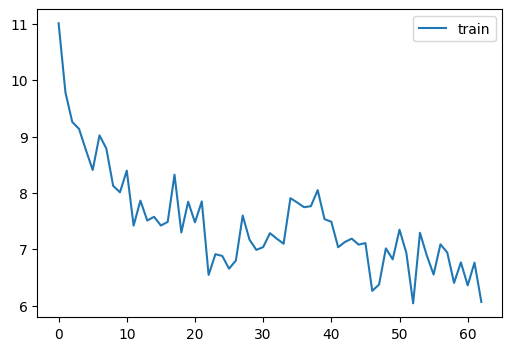

In [25]:
stats = ActivationStats(fc.risinstance(Block))
set_seed(1)
model = GPT(GPTConfig())
cbs = [TrainCB(), DeviceCB(), MetricsCB(), ProgressCB(plot=True)]
lrn = fit(model, xtra_cbs=[stats])

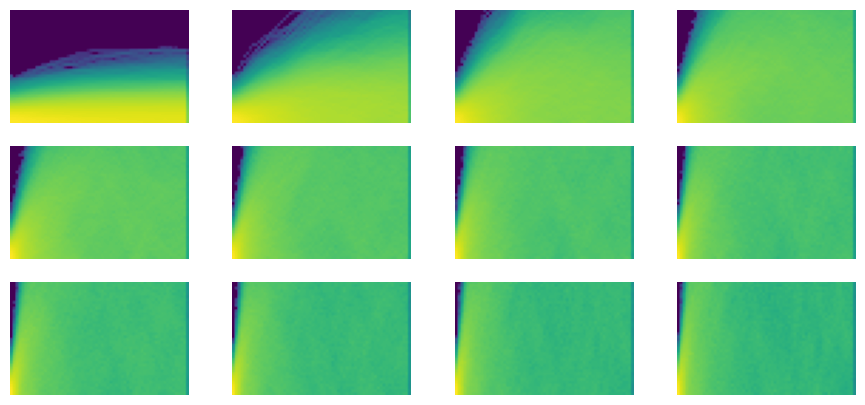

In [26]:
stats.color_dim()

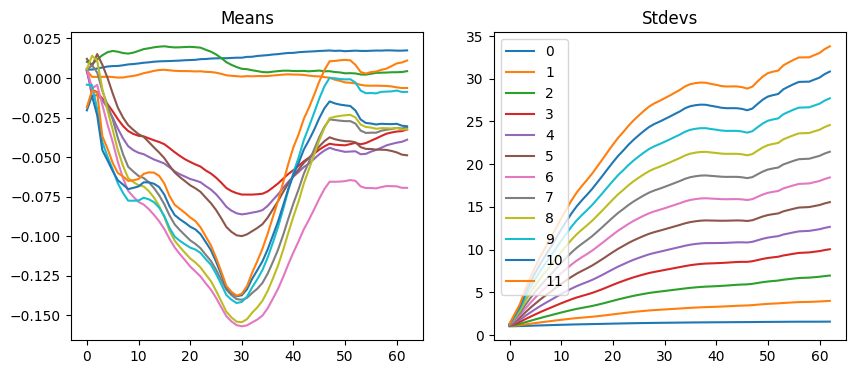

In [27]:
stats.plot_stats()

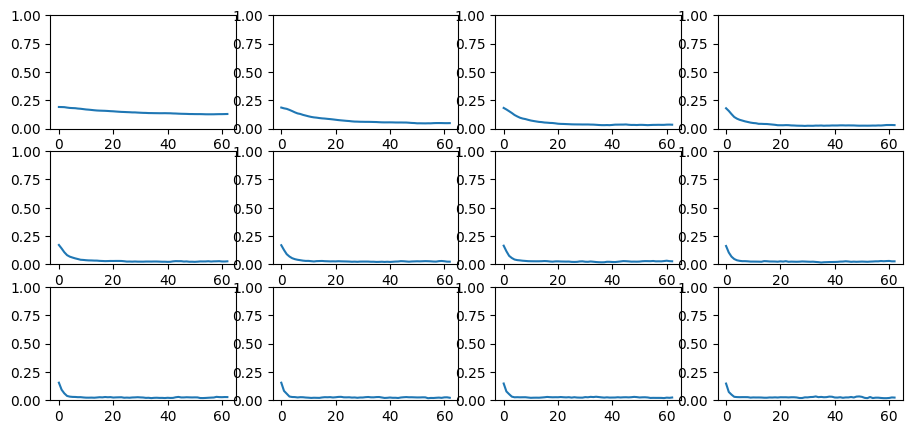

In [28]:
stats.dead_chart()

In [29]:
#|export
class InitWeightsCB(Callback):
    def before_fit(self, learn):
        model = learn.model
        model.apply(init_weights)

loss,epoch,train
7.478,0,train


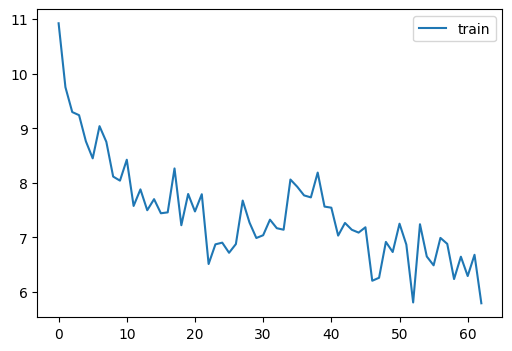

In [30]:
stats = ActivationStats(fc.risinstance(Block))
model = get_model()
lrn = fit(model, xtra_cbs=[InitWeightsCB(), stats])

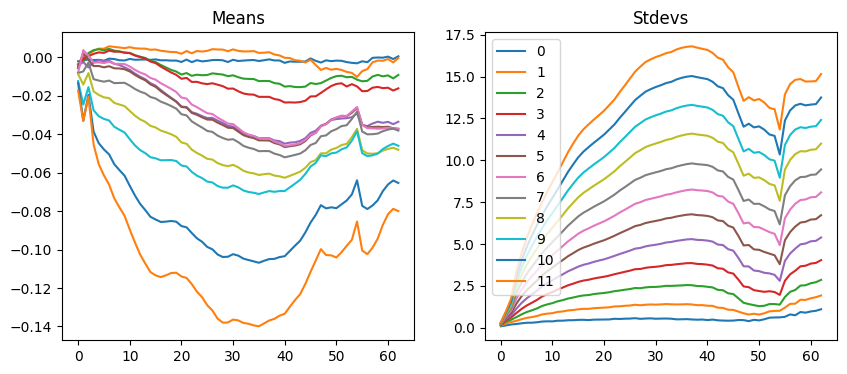

In [31]:
stats.plot_stats()

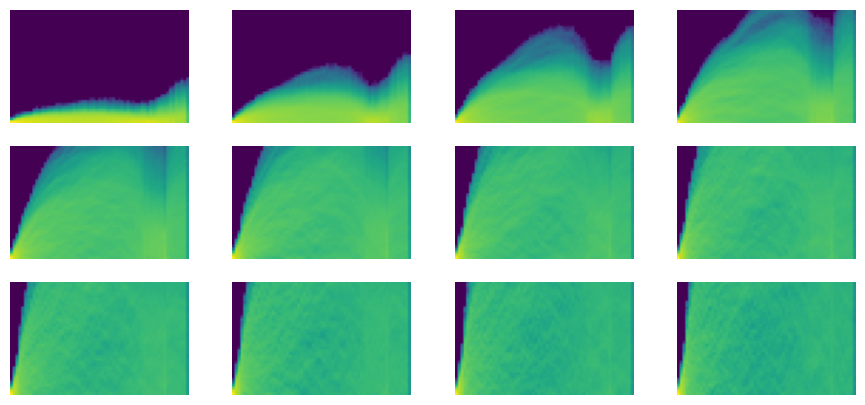

In [32]:
stats.color_dim()